Making a decision about ComEd hourly pricing
---------------------------------

ComEd, our power company, has started offering hourly pricing for electricity. I wanted to see whether it would be worth switching. I'm going to show what I did, and teach a few principles about web scraping and data analysis along the way.

Finding the data
--------------

ComEd does a great job of storing and visualizing my historical usage, at https://secure.comed.com/MyAccount/MyBillUsage/pages/secure/ViewMyUsage.aspx. My original plan was to use the great [requests library](http://docs.python-requests.org/en/master/) to log in and then scrape the data directly.

However, using the network monitor in the [Firefox developer tools](https://developer.mozilla.org/en-US/docs/Tools) I was able to look at the requests that my browser was making, and figured out that ComEd actually gets this data from opower, and one of their requests had the exact data I wanted. So, instead of scraping I could just use that hidden API.

If you would like to do this, you'll need to follow the same steps I did.

1. Log in to ComEd, and visit https://secure.comed.com/MyAccount/MyBillUsage/pages/secure/ViewMyUsage.aspx, with Firefox developer tools open to the network monitor page
2. Examine the network requests and look for a GET request that's something like:
https://cec.opower.com/ei/edge/apis/DataBrowser-v1/cost/utilityAccount/3f5cbeff-3c53-11e4-ba8c-1b40f3043709?startDate=2016-06-14T05:00+0000&endDate=2018-06-13T05:00+0000&aggregateType=bill
3. The long string in the middle is the uid that opower uses to refer to your account. Mine is '3f5cbeff-3c53-11e4-ba8c-1b40f3043709'. Copy that and save it as the `uid` variable below.
4. Open the 'storage' tab in Firefox developer tools, go to the opower cookies, and copy and paste the JSESSIONID cookie into the JSESSIONID spot in the cookies dictionary below.

Setting variables
-------
First, we load libraries and set variables. Currently, this gets data for all of 2017


In [362]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# Replace the JSESSIONID with the one from your browser
cookies = {"cookie-check" : "true",
"JSESSIONID" : "40a59fef-6bff-464c-838b-eaba043d5ed7"}

uid = '3f5cbeff-3c53-11e4-ba8c-1b40f3043709'

params = {'startDate': '2017-01-01',
         'endDate': '2017-12-01', # After some playing around, I learned this can be a max of ~11 months
         'aggregateType': 'hour'}

## Getting usage information

This makes a request to opower to get usage information from the time period specified above. Any problems with the uid or JSESSIONID will show up here, and you'll get an error message.

Note that these session ids will expire and this will only work while you are logged into ComEd.

In [363]:
r = requests.get('https://cec.opower.com/ei/edge/apis/DataBrowser-v1/cost/utilityAccount/{}'.format(uid),
               cookies = cookies,
                params = params)
usage = r.json()['reads']

In [354]:
# Simple function to change the datetime string into a datetime object and remove the timezone offset
def to_dt(s):
    s = s[:-3] + s[-2:]
    with_tz = datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.000%z')
    return (with_tz - with_tz.utcoffset()).replace(tzinfo = None)

In [364]:
# This saves the usage information as a dataframe
usage = pd.DataFrame([{'startTime' : to_dt(x['startTime']),
  'energy_used' : x['value']
 } for x in usage])

# We take the startTime and make it the index of the dataframe
usage = usage.set_index(pd.DatetimeIndex(usage.startTime))
# And then just keep the column we're interested in - the energy used.
usage = usage.energy_used

In [365]:
usage.tail()

startTime
2017-12-01 01:00:00    1.2200
2017-12-01 02:00:00    0.9875
2017-12-01 03:00:00    0.4675
2017-12-01 04:00:00    0.4625
2017-12-01 05:00:00    0.3325
Name: energy_used, dtype: float64

We now have usage, which is a pandas Series of how much energy I used each hour of each day in 2017.

Let's plot how much we used per week.

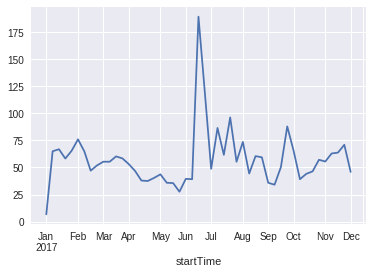

In [366]:
# Resample takes a time series, and aggregates it by the string passed to it. 'W' is for week.
usage.resample('W').sum().plot() 

Next, we can get the prices. This is from a public API.

In [367]:
# The parameters are a bit different, so we edit the params dictionary
params['datestart'] = datetime.strftime(datetime.strptime(params['startDate'], '%Y-%m-%d'), '%Y%m%d%H%M')
params['dateend'] = datetime.strftime(datetime.strptime(params['endDate'], '%Y-%m-%d'), '%Y%m%d%H%M')

r = requests.get('https://hourlypricing.comed.com/api?type=5minutefeed',
                 params = params,
                cookies = cookies)
prices = r.json()

In [368]:
# Again, we make a dataframe
prices = pd.DataFrame(prices)
# This time, the date is a timestamp, but we still convert it to datetime and save it as the index
prices = prices.set_index(pd.DatetimeIndex(
    prices['millisUTC'].apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))))
# And again, we discard what we don't need and save just the prices as a series
prices = prices.price.apply(float)

I think digging into this price data could be really interesting, but this is a superficial plot of the weekly prices. Notice that the average weekly price never gets above 4.5 cents per kwh, which is much lower than the ~6.5-7 cents that you get with flat pricing.

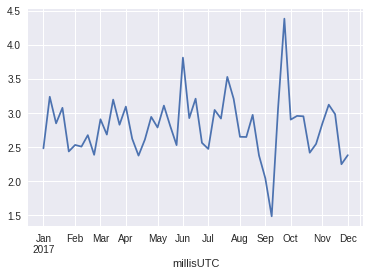

In [369]:
prices.resample('W').mean().plot()

Let's look at the worst-case examples. Here are the 10 highest priced hours.

In [503]:
worst_prices = prices.resample('H').mean().sort_values(ascending = False).head(10)
worst_prices

millisUTC
2017-09-21 18:00:00    74.425000
2017-09-21 20:00:00    55.150000
2017-07-06 19:00:00    39.783333
2017-09-21 19:00:00    25.970000
2017-07-27 14:00:00    19.425000
2017-09-20 21:00:00    17.483333
2017-09-20 18:00:00    17.241667
2017-09-22 18:00:00    15.308333
2017-07-26 17:00:00    14.933333
2017-07-19 20:00:00    14.358333
Name: price, dtype: float64

And they are pretty high - let's see what the worst case, most expensive hour of electricity might be. Here are my top usage hours.

In [504]:
highest_use = usage.sort_values(ascending = False).head(10)
highest_use

startTime
2017-06-18 05:00:00    4.6050
2017-06-12 22:00:00    4.5925
2017-06-12 23:00:00    4.4500
2017-06-18 03:00:00    4.4500
2017-06-18 04:00:00    4.4100
2017-08-01 00:00:00    4.4075
2017-06-18 06:00:00    4.3325
2017-07-07 02:00:00    4.2825
2017-06-13 00:00:00    4.2450
2017-06-11 22:00:00    4.2425
Name: energy_used, dtype: float64

Here are the worst possible outcomes, if my highest hours happened at the most expensive times. The worst one is $3.42

In [505]:
pd.Series(worst_prices.values * highest_use.values)/100

0    3.427271
1    2.532764
2    1.770358
3    1.155665
4    0.856643
5    0.770578
6    0.746995
7    0.655579
8    0.633920
9    0.609152
dtype: float64

I then put all of these into a dataframe, to make sure that the dates match up.

In [389]:
mean_prices = prices.resample('H').mean()
df = pd.DataFrame({'usage' : usage,
                  'price' : mean_prices})


It's always a good idea to make sure that the data look good. Let's check for NAs:


In [388]:
df[df.isna().any(axis=1)]

,price,usage
2017-03-19 22:00:00,NaN,0.1775
2017-03-19 23:00:00,NaN,0.2225
2017-03-20 00:00:00,NaN,0.2475
2017-03-20 01:00:00,NaN,0.1775
2017-03-30 05:00:00,NaN,0.1200
2017-03-30 06:00:00,NaN,0.1075
2017-03-30 07:00:00,NaN,0.1250
2017-03-30 08:00:00,NaN,0.1325
2017-03-30 09:00:00,NaN,0.0925
2017-03-30 10:00:00,NaN,0.1325


The prices are missing for a few days in March, which is odd. I have no idea why there is one missing row in November.

There are a number of ways of dealing with missing data. For our purposes, I'm looking for a rough estimate, and using a linear interpolation for the rows for which we have data seems a reasonable estimate. Pandas has this built in.

In [391]:
df = df.interpolate(method='time')

This is what it looks like. It just draws a straight line from the last known data point to the next known data point.

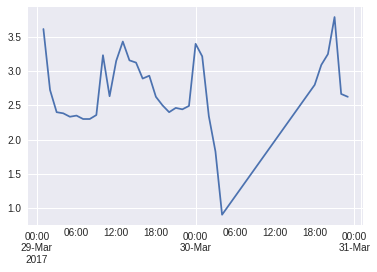

In [394]:
df.price[(df.index > '2017-03-29') & (df.index < '2017-03-31')].plot()

Let's look at the worst-case examples. Here are the 10 highest priced hours.

In [507]:
worst_prices = df.price.resample('H').mean().sort_values(ascending = False).head(10)
worst_prices

2017-09-21 18:00:00    74.425000
2017-09-21 20:00:00    55.150000
2017-07-06 19:00:00    39.783333
2017-09-21 19:00:00    25.970000
2017-07-27 14:00:00    19.425000
2017-09-20 21:00:00    17.483333
2017-09-20 18:00:00    17.241667
2017-09-22 18:00:00    15.308333
2017-07-26 17:00:00    14.933333
2017-07-19 20:00:00    14.358333
Name: price, dtype: float64

And they are pretty high - let's see what the worst case, most expensive hour of electricity might be. Here are my top usage hours.

In [504]:
highest_use = usage.sort_values(ascending = False).head(10)
highest_use

startTime
2017-06-18 05:00:00    4.6050
2017-06-12 22:00:00    4.5925
2017-06-12 23:00:00    4.4500
2017-06-18 03:00:00    4.4500
2017-06-18 04:00:00    4.4100
2017-08-01 00:00:00    4.4075
2017-06-18 06:00:00    4.3325
2017-07-07 02:00:00    4.2825
2017-06-13 00:00:00    4.2450
2017-06-11 22:00:00    4.2425
Name: energy_used, dtype: float64

Here are the worst possible outcomes, if my highest hours happened at the most expensive times. The worst one is $3.42

In [505]:
pd.Series(worst_prices.values * highest_use.values)/100

0    3.427271
1    2.532764
2    1.770358
3    1.155665
4    0.856643
5    0.770578
6    0.746995
7    0.655579
8    0.633920
9    0.609152
dtype: float64

To get how much I would have paid for electricity, I multiply the mean hourly prices by the amount of electricity I used in that hour.

In [395]:
hourly_cost = (df.price * df.usage)/100 # Divide by 100 since these are cents.

Now, when we look at the total cost, it's similar to the usage plot, but October is a lot more expensive, because of the high cost.

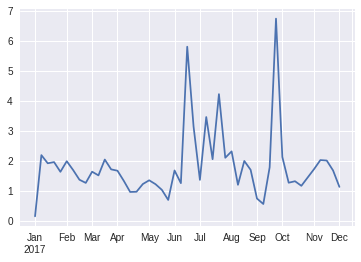

In [398]:
hourly_cost.resample('W').sum().plot()

And so what are my actual most expensive hours I would have had (remember, $3.42 was the worst possible)

In [501]:
hourly_cost.sort_values(ascending = False).head()

2017-09-21 20:00:00    1.702756
2017-09-21 18:00:00    0.997295
2017-07-06 19:00:00    0.618631
2017-06-12 21:00:00    0.355117
2017-09-21 21:00:00    0.279870
dtype: float64

Only one hour above \$1, and only 3 above \$0.50.

## Getting real bills

Finally, I can make some estimates, and compare to my actual bills. https://secure.comed.com/MyAccount/MyBillUsage/Pages/Secure/AccountHistory.aspx shows bills. I couldn't scrape this easily for this data, so I just copied it.

*Note*: Make sure to just get the supplier portion - not the whole bill.

In [467]:
bills = pd.DataFrame([('12/01/2017', 20.16),
('10/31/2017', 14.66),
('10/02/2017', 16.73),
('09/01/2017', 15.47),
('08/03/2017', 22.93),
('07/05/2017', 29.29),
('06/05/2017', 10.21),
('05/04/2017', 11.88),
('04/05/2017', 16.43),
('03/07/2017', 17.54),
('02/06/2017', 19.57),
('01/05/2017', 20.37),
], columns = ['date', 'amount'])

bills = bills.set_index(pd.DatetimeIndex(bills.date)).amount
bills = bills.sort_index()

Here's the plot. Spring and fall are great, but summer and winter are killers.

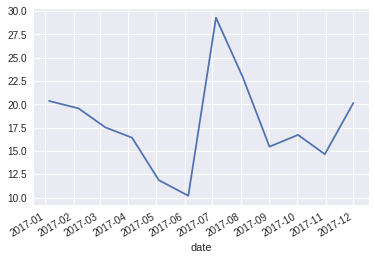

In [468]:
bills.plot()

Now, let's combine the two data sources. I'm sure there's a fancy way to do this with pandas, but I'm going back to a good old-fashioned for loop.

In [448]:
start_date = None
hourly_estimate = [] # List to store the estimates for the hourly pricing
for end_date in bills.index: # Loop through the dates of the bills
    if start_date: # We have to start on the second bill
        # And then we just get the sum of the hourly costs from the time of the first bill to the time of the
        # current bill
        hourly_estimate.append(sum(hourly_cost[(hourly_cost.index > start_date) & 
                                         (hourly_cost.index <= end_date)]))
    start_date = end_date # And reset the start date to the current bill date
        

## The final plot


And then combine these into a dataframe, and make the plot that all this work was for.

In [469]:
comparison = pd.DataFrame({'hourly_estimate': [None] + hourly_estimate,
                           'current' : bills})

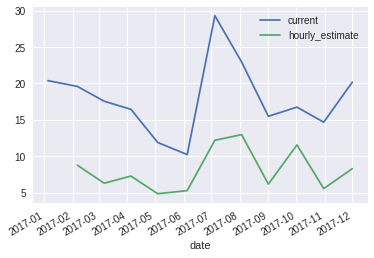

In [470]:
comparison.plot()

Whoa! It looks like this would save us money, every month without exception, and without changing behavior. I thought that we'd see at least the summer be more expensive but that's actually the greatest delta.

Here's an estimate of how much we would save each month.

In [473]:
(comparison.current - comparison.hourly_estimate)

date
2017-01-05          NaN
2017-02-06    10.822409
2017-03-07    11.259954
2017-04-05     9.166607
2017-05-04     7.046169
2017-06-05     4.947289
2017-07-05    17.110177
2017-08-03     9.978337
2017-09-01     9.316502
2017-10-02     5.188789
2017-10-31     9.118162
2017-12-01    11.883152
dtype: float64

And how much would we save in the year?

In [500]:
(comparison.current - comparison.hourly_estimate).sum()

105.8375473419011

## The Decision

This analysis shows that for us, moving to hourly pricing is an easy decision, and I signed up!